In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.keras.datasets import mnist

In [2]:
# enable eager execution
tf.enable_eager_execution()
tf.set_random_seed(123456)
np.random.seed(654321)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# reshape images to [size, 784]
x_train = x_train.reshape(-1, 784).astype(np.float32)
x_test = x_test.reshape(-1, 784).astype(np.float32)

# one-hot encode labels
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

In [5]:
class FeedForwardNeuralNetwork(tf.keras.Model):
    def __init__(self):
        super(FeedForwardNeuralNetwork, self).__init__()
        
        # create the first hidden layer with 512 units,
        # accepting an input with shape (784),
        # uses relu function, 
        # with bias parameters
        self.hidden_layer_1 = tf.layers.Dense(512, input_shape=(784,), activation=tf.nn.relu, use_bias=True)
        
        # create a second hidden layer with 256 units,
        # uses relu function,
        # with bias parameters
        self.hidden_layer_2 = tf.layers.Dense(256, activation=tf.nn.relu, use_bias=True)
        
        # add dropout
        self.dropout = tf.layers.Dropout()
        
        # create a linear layer for class predictions
        self.output_layer = tf.layers.Dense(10, use_bias=True, activation=None)
        
    def call(self, x):
        # stack hidden layers
        h1 = self.hidden_layer_1(x)
        h2 = self.hidden_layer_2(h1)
        h2 = self.dropout(h2)
        
        # return logits when called to produce predictions
        return self.output_layer(h2)

In [6]:
model = FeedForwardNeuralNetwork()

In [7]:
def loss(model, logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model(logits), labels=labels))

In [8]:
opt = tf.train.AdamOptimizer(learning_rate=1e-3)

In [9]:
def train_step(loss, model, opt, x, y):
    opt.minimize(lambda: loss(model, x, y), global_step=tf.train.get_or_create_global_step())

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

epochs = 20
accuracy_history = np.zeros(epochs)
writer = tf.contrib.summary.create_file_writer('tmp')

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch in range(epochs):
            accuracy = tfe.metrics.Accuracy()
            
            for x_batch, y_batch in tfe.Iterator(train_dataset.shuffle(1000).batch(512)):
                
                x_batch += tf.random_normal(shape=x_batch.shape, stddev=5e-2)
                
                tf.contrib.summary.scalar('loss_value', loss(model, x_batch, y_batch))
                
                train_step(loss, model, opt, x_batch, y_batch)
                
                accuracy(tf.argmax(model(tf.constant(x_batch)), axis=1), tf.argmax(tf.constant(y_batch), axis=1))
                
                tf.contrib.summary.scalar('accuracy_value', accuracy.result().numpy())
                
            accuracy_history[epoch] = accuracy.result().numpy()

In [12]:
test_accuracy = tf.contrib.metrics.accuracy(predictions=tf.argmax(model(tf.constant(x_test)), axis=1),
                                            labels=tf.argmax(tf.constant(y_test), axis=1))

In [13]:
test_accuracy.numpy()

0.965

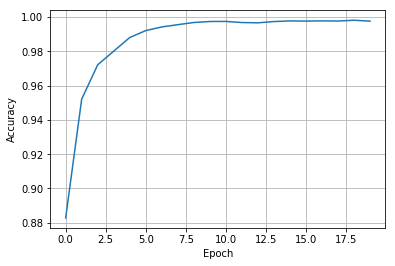

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(accuracy_history)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()